# Compute global annual anomalies

In [146]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import xarray as xr
import intake
import pprint 
import util 
import os

## define functions

def calendar_check(model):
    # Time formats for piControl, found from manual check:
    if model in ['TaiESM1', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-CM4', 'SAM0-UNICON', 'GFDL-ESM4', 'CIESM', 'MCM-UA-1-0']:
        ds_calendar = 'noleap'
    elif model in ['CNRM-CM6-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'NESM3']:
        ds_calendar = 'gregorian'
    elif model in ['AWI-CM-1-1-MR', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR']:
        ds_calendar = 'proleptic_gregorian'
    elif model in ['UKESM1-0-LL', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'CNRM-ESM2-1', 'KACE-1-0-G', 'MRI-ESM2-0']:
        ds_calendar = '360_day'
        if model in ['CNRM-ESM2-1', 'MRI-ESM2-0']:
            print('piControl is 360_day, the other experiments unknown')
    elif model in ['IITM-ESM']:
        ds_calendar = 'Julian'
    elif model in ['AWI-ESM-1-1-LR', 'CNRM-CM6-1-HR', 'EC-Earth3', 'EC-Earth3-LR']:
        #ds_calendar = 'datetime64'
        print('not 100% sure what calendar this model has, but a guess is made based on other models from same institution')
        if model in ['EC-Earth3', 'EC-Earth3-LR', 'AWI-ESM-1-1-LR']:
            print('calendar is likely proleptic gregorian')
            ds_calendar = 'proleptic_gregorian'
        elif model in ['CNRM-CM6-1-HR']:
            print('calendar is likely gregorian')
            ds_calendar = 'gregorian'
    return ds_calendar

# function copied from: http://xarray.pydata.org/en/stable/examples/monthly-means.html
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap


# days per month:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], ##### I think this should be correct
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
      }

# days per year
def dpy(model, start_year, end_year):
    ds_calendar = calendar_check(model) 
    leap_boolean = [leap_year(year, calendar = ds_calendar) for year in range(start_year, end_year)]
    leap_int = np.multiply(leap_boolean,1)
    
    noleap_dpy = np.array(dpm[ds_calendar]).sum()
    leap_dpy = noleap_dpy + leap_int
    return leap_dpy  

## Choose model and experiment

In [181]:
#model = 'GISS-E2-1-G'
model = 'AWI-CM-1-1-MR'

In [207]:
#exp = 'piControl'
#exp = 'abrupt-4xCO2'
#exp = 'abrupt-2xCO2'
#exp = 'abrupt-0p5xCO2'

#exp = 'historical'
#exp = 'ssp126'
#exp = 'ssp245'
#exp = 'ssp370'
exp = 'ssp585'

In [208]:
branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.txt'
table = pd.read_table(branch_time_file,index_col=0, sep = ' ')
table

,model,exp,member,parent_experiment_id,parent_variant_id,branch_time_in_child,branch_time_in_parent,parent_time_units,branch_method
0,AWI-CM-1-1-MR,abrupt-4xCO2,r1i1p1f1,piControl,r1i1p1f1,0.0,90945.0,days since 2401-01-01 00:00:00,standard
1,AWI-CM-1-1-MR,ssp245,r1i1p1f1,historical,r1i1p1f1,0.0,60265.0,days since 1850-01-01 00:00:00,standard
2,AWI-CM-1-1-MR,historical,r1i1p1f1,piControl,r1i1p1f1,0.0,54421.0,days since 2401-01-01 00:00:00,standard
3,AWI-CM-1-1-MR,historical,r2i1p1f1,piControl,r1i1p1f1,0.0,63552.0,days since 2401-01-01 00:00:00,standard
4,AWI-CM-1-1-MR,historical,r3i1p1f1,piControl,r1i1p1f1,0.0,72683.0,days since 2401-01-01 00:00:00,standard
5,AWI-CM-1-1-MR,historical,r4i1p1f1,piControl,r1i1p1f1,0.0,81814.0,days since 2401-01-01 00:00:00,standard
6,AWI-CM-1-1-MR,historical,r5i1p1f1,piControl,r1i1p1f1,0.0,90945.0,days since 2401-01-01 00:00:00,standard
7,AWI-CM-1-1-MR,piControl,r1i1p1f1,piControl-spinup,r1i1p1f1,0.0,0.0,days since 1901-01-01 00:00:00,standard
8,AWI-CM-1-1-MR,ssp585,r1i1p1f1,historical,r1i1p1f1,0.0,60265.0,days since 1850-01-01 00:00:00,standard
9,AWI-CM-1-1-MR,ssp370,r1i1p1f1,historical,r1i1p1f1,0.0,60265.0,days since 1850-01-01 00:00:00,standard


54421.0
54421
days difference: 0.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year


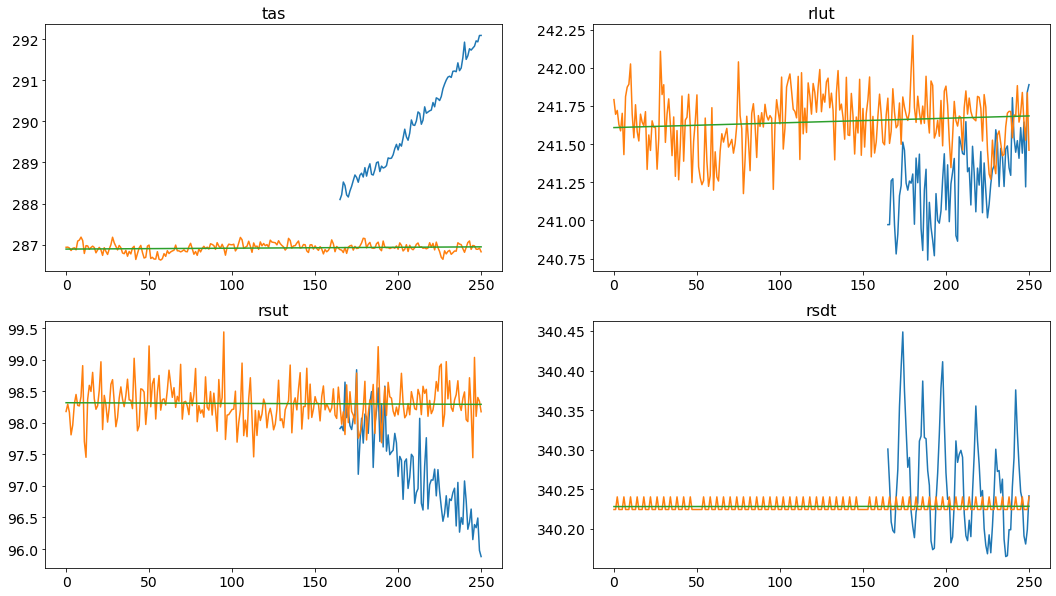

In [209]:
plot_absolute_values = True
plot_anomalies = False
save_results = True

expgroup0 = ['piControl']
expgroup1 = ['abrupt-4xCO2', 'abrupt-2xCO2', 'abrupt-0p5xCO2']
expgroup2 = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

piControl_path = '../Processed_data/Global_annual_means/' + model + '/piControl/'
exp_path = '../Processed_data/Global_annual_means/' + model + '/' + exp + '/'

exptable = table.loc[table['exp'] == exp]
available_members = exptable['member'].values

for member in available_members:
    member_df = exptable.loc[exptable['member'] == member]

    # load exp data
    exp_filename = model + '_' + exp + '_' + member + '_means.txt'
    exp_data = pd.read_table(exp_path + exp_filename, index_col=0, sep = ',')
    
    if plot_absolute_values == True:
        fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes = np.reshape(ax, 4)
    if plot_anomalies == True:
        fig, ax2 = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes2 = np.reshape(ax2, 4)

    if exp in expgroup1 or exp in expgroup2:
        if exp in expgroup1 or exp == 'historical':
            branch_time_days = member_df['branch_time_in_parent'].values[0]
            piControl_member = member_df['parent_variant_id'].values[0]
            
        elif exp in expgroup2: # then ssp. check branch for historical parent only
            # find historical parent member 
            parent_member = member_df['parent_variant_id'].values[0]
            parent_table = table.loc[table['exp'] == 'historical']
            parent_df = parent_table.loc[parent_table['member'] == parent_member]
            branch_time_days = parent_df['branch_time_in_parent'].values[0]
            piControl_member = parent_df['parent_variant_id'].values[0]
        if model == 'MPI-ESM1-2-HR' and exp in expgroup2:
            piControl_member = 'r1i1p1f1' # overwrite info from file, which seems to be wrong
        # load piControl values. 
        piControl_filename = model + '_piControl_' + piControl_member + '_means.txt'
        piControl_data = pd.read_table(piControl_path + piControl_filename, index_col=0, sep = ',')
        
        piControl_start_year = int(table.loc[table['parent_experiment_id'] == 'piControl']['parent_time_units'][0][11:15])
        days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+1000)))    
        # find index of element closest to branch_time_days
        year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
        
        print(branch_time_days)
        print(days_table[year_since_piControl_start])
        print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        print('differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year')
        
    for (i,var) in enumerate(['tas', 'rlut', 'rsut', 'rsdt']):
        exp_len = len(exp_data[var])
        if exp in expgroup0:
            # then just subtract a linear trend from all values
            y = exp_data[var]
            x = np.arange(exp_len)
            datarange = np.arange(exp_len)
        elif exp in expgroup1:
            y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+exp_len)] # Use only years corresponding to exp years
            x = np.arange(exp_len)
            datarange = np.arange(exp_len)
        elif exp in expgroup2:
            x = np.arange(251) # number of years in interval (1850 - 2100)
            y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+251)] # Use historical + ssp years (1850 - 2100)
            if exp == 'historical':
                datarange = np.arange(165)
            else:
                datarange = np.arange(165,len(x))

        if len(y) == len(x):
            p1 = np.polyfit(x,y,1)
        elif len(y) < len(x):
            p1 = np.polyfit(x[:len(y)],y,1) # make a fit from the data we have available
        lintrend = np.polyval(p1,x)
            
        annual_anomalies = exp_data[var] - lintrend[datarange]
        if var == 'tas':
            # create dataframe for storing anomalies
            exp_anomalies = pd.DataFrame(annual_anomalies.values, columns = [var])
        else:
            df_col = pd.DataFrame(annual_anomalies.values, columns = [var])
            exp_anomalies = pd.merge(exp_anomalies, df_col, left_index=True, right_index=True, how='outer')

        if plot_absolute_values == True: # plot abolute values and trends
            axes[i].plot(x[datarange], exp_data[var])
            axes[i].plot(x[:len(y)], y)
            axes[i].plot(x, lintrend)
            axes[i].set_title(var, fontsize = 16)
            axes[i].tick_params(axis='both',labelsize=14)
        if plot_anomalies == True: # plot anomalies for visual check:
            axes2[i].plot(x, exp_anomalies[var])
            axes2[i].set_title(x, var, fontsize = 16)
            axes2[i].tick_params(axis='both',labelsize=14) 

    if save_results == True:
        filename = model + '_' + exp + '_' + member + '_anomalies.txt'
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        if member == available_members[0]: # create directory for first member
            os.makedirs(os.path.dirname(file), exist_ok=False)

        exp_anomalies.to_csv(file)
            
            

In [210]:
exp_anomalies

,tas,rlut,rsut,rsdt
0,1.169241,-0.686341,-0.392657,0.072444
1,1.284143,-0.686583,-0.354406,0.029341
2,1.594524,-0.399764,-0.426279,-0.019640
3,1.509356,-0.386443,0.342936,-0.030560
4,1.280294,-0.687812,-0.218764,-0.033378
...,...,...,...,...
81,4.879868,-0.242914,-1.904519,0.008146
82,5.008846,-0.039232,-1.954096,-0.037577
83,4.985243,-0.464134,-1.800612,-0.047662
84,5.138887,0.158419,-2.313773,-0.029690
